In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE

import statsmodels.api as sm

from sklearn.metrics import classification_report

In [2]:
xy_df = pd.read_csv('xy.csv')
print(xy_df.shape)
xy_df.head()

(1136496, 23)


,strike_given_called,upm,home_pitcher,run_diff,count_0-1,count_0-2,count_1-0,count_1-1,count_1-2,count_2-0,...,count_3-1,count_3-2,inning_2,inning_3,inning_4,inning_5,inning_6,inning_7,inning_8,inning_9
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
cp_merged_df = pd.read_csv('cp_merged.csv')
print(cp_merged_df.shape)
cp_merged_df = cp_merged_df[(cp_merged_df['count'] != '4-2') & (cp_merged_df['count'] != '4-1')]
print(cp_merged_df.shape)
cp_merged_df.head()

(1136501, 7)
(1136496, 7)


,count,home_pitcher,inning,run_diff,strike_given_called,pitcher_race,umpire_race
0,0-0,1,1,0,True,white,white
1,0-0,1,1,0,False,white,white
2,1-1,1,1,0,True,white,white
3,1-2,1,1,0,False,white,white
4,0-0,1,1,0,False,white,white


# Data Exploration

In [4]:
xy_df['strike_given_called'].value_counts()

0    763303
1    373193
Name: strike_given_called, dtype: int64

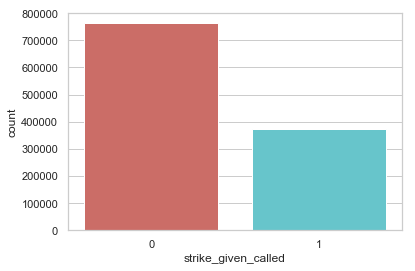

In [28]:
sns.countplot(x='strike_given_called', data=xy_df, palette='hls')
plt.savefig('strike_count', bbox_inches='tight')
plt.show()

### Observations:
- Ratio of strike and ball calls is imbalanced. Rebalancing is necessary.

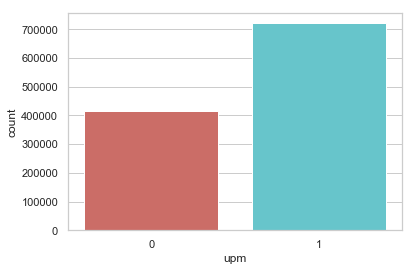

In [31]:
sns.countplot(x='upm', data=xy_df, palette='hls')
plt.savefig('ump_count', bbox_inches='tight')
plt.show()

### Observations:
- The umpire and pitcher are more likely to be the same race than not.

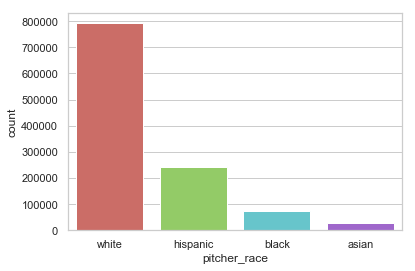

In [29]:
sns.countplot(x='pitcher_race', data=cp_merged_df, palette='hls')
plt.savefig('pitcher_race_count', bbox_inches='tight')
plt.show()

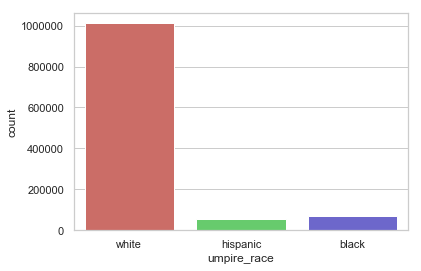

In [30]:
sns.countplot(x='umpire_race', data=cp_merged_df, palette='hls')
plt.savefig('umpire_race_count', bbox_inches='tight')
plt.show()

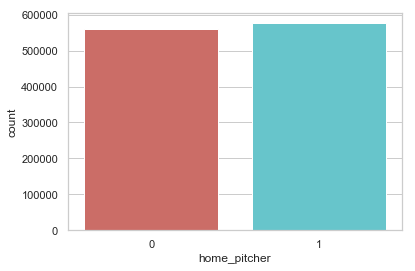

In [9]:
sns.countplot(x='home_pitcher', data=xy_df, palette='hls')
plt.savefig('home_count', bbox_inches='tight')
plt.show()

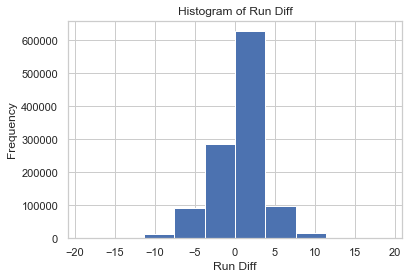

In [10]:
xy_df.run_diff.hist()
plt.title('Histogram of Run Diff')
plt.xlabel('Run Diff')
plt.ylabel('Frequency')
plt.savefig('rundiff_hist', bbox_inches='tight')

In [11]:
xy_df.groupby('strike_given_called').mean()

,upm,home_pitcher,run_diff,count_0-1,count_0-2,count_1-0,count_1-1,count_1-2,count_2-0,count_2-1,...,count_3-1,count_3-2,inning_2,inning_3,inning_4,inning_5,inning_6,inning_7,inning_8,inning_9
strike_given_called,,,,,,,,,,,,,,,,,,,,,
0,0.634439,0.504966,0.029290,0.148959,0.081443,0.096568,0.098484,0.098644,0.029300,0.041669,...,0.016040,0.027558,0.110779,0.110044,0.111865,0.109773,0.112033,0.111325,0.109895,0.105822
1,0.634771,0.511548,0.140201,0.083898,0.014625,0.140547,0.067236,0.022677,0.052179,0.035360,...,0.020523,0.013098,0.117770,0.115487,0.107609,0.107958,0.104897,0.106979,0.106626,0.106749


### Observations:
- The percentage of pitches thrown by the home team that are called strikes is higher than that of pitches thrown by the away team. Pitchers playing at home receive more strike calls.
- The average run differential of pitches called strike is higher than that of pitches called ball. Pitches called strike are more likely to be thrown by the team in the lead.

In [12]:
xy_df.mean()

strike_given_called    0.328372
upm                    0.634548
home_pitcher           0.507127
run_diff               0.065710
count_0-1              0.127595
count_0-2              0.059502
count_1-0              0.111010
count_1-1              0.088223
count_1-2              0.073698
count_2-0              0.036813
count_2-1              0.039597
count_2-2              0.050884
count_3-0              0.017720
count_3-1              0.017512
count_3-2              0.022810
inning_2               0.113075
inning_3               0.111831
inning_4               0.110468
inning_5               0.109177
inning_6               0.109690
inning_7               0.109898
inning_8               0.108821
inning_9               0.106126
dtype: float64

In [13]:
xy_df.groupby('upm').mean()

,strike_given_called,home_pitcher,run_diff,count_0-1,count_0-2,count_1-0,count_1-1,count_1-2,count_2-0,count_2-1,...,count_3-1,count_3-2,inning_2,inning_3,inning_4,inning_5,inning_6,inning_7,inning_8,inning_9
upm,,,,,,,,,,,,,,,,,,,,,
0,0.328171,0.507855,0.063804,0.126816,0.059304,0.111898,0.087833,0.073230,0.037283,0.039874,...,0.017465,0.023186,0.113359,0.112288,0.110323,0.109560,0.107985,0.106500,0.106598,0.111163
1,0.328487,0.506708,0.066808,0.128044,0.059616,0.110498,0.088448,0.073968,0.036542,0.039438,...,0.017538,0.022593,0.112911,0.111569,0.110551,0.108956,0.110672,0.111856,0.110102,0.103225


### Observations:
- The percentage of strike calls is slightly higher when the umpire and pitcher are the same race.
- Home pitchers are slightly more likely to have an umpire of a different race.
- The average run differential of pitches called by an umpire of the same race is higher than that of pitches called by an umpire of a different race. On average, the team whose current pitcher is the same race as the umpire is more likely to be in the lead.

In [14]:
xy_df.groupby('home_pitcher').mean()

,strike_given_called,upm,run_diff,count_0-1,count_0-2,count_1-0,count_1-1,count_1-2,count_2-0,count_2-1,...,count_3-1,count_3-2,inning_2,inning_3,inning_4,inning_5,inning_6,inning_7,inning_8,inning_9
home_pitcher,,,,,,,,,,,,,,,,,,,,,
0,0.325426,0.635088,0.209509,0.126349,0.058045,0.112435,0.088295,0.072759,0.037967,0.039938,...,0.018049,0.022948,0.115586,0.114116,0.113690,0.111176,0.112954,0.112533,0.111112,0.082389
1,0.331234,0.634023,-0.074047,0.128806,0.060918,0.109625,0.088153,0.074611,0.035692,0.039266,...,0.016990,0.022676,0.110635,0.109611,0.107336,0.107234,0.106517,0.107338,0.106595,0.129196


### Observations:
- Home pitchers are more likely to receive strike calls.
- Home pitchers are more likely to be on the team behind. This is affected by the fact that the home team always pitches in the top of the inning; the away team has had more at-bats than the home team.

In [15]:
xy_df.groupby('count_3-2').mean()

,strike_given_called,upm,home_pitcher,run_diff,count_0-1,count_0-2,count_1-0,count_1-1,count_1-2,count_2-0,...,count_3-0,count_3-1,inning_2,inning_3,inning_4,inning_5,inning_6,inning_7,inning_8,inning_9
count_3-2,,,,,,,,,,,,,,,,,,,,,
0,0.331635,0.634689,0.507197,0.067044,0.130573,0.060891,0.113601,0.090282,0.075419,0.037672,...,0.018134,0.01792,0.113170,0.111979,0.110455,0.109242,0.109717,0.109829,0.108689,0.106028
1,0.188558,0.628515,0.504147,0.008564,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.109015,0.105505,0.111021,0.106392,0.108514,0.112873,0.114493,0.110327


In [16]:
xy_df.groupby('count_3-1').mean()

,strike_given_called,upm,home_pitcher,run_diff,count_0-1,count_0-2,count_1-0,count_1-1,count_1-2,count_2-0,...,count_3-0,count_3-2,inning_2,inning_3,inning_4,inning_5,inning_6,inning_7,inning_8,inning_9
count_3-1,,,,,,,,,,,,,,,,,,,,,
0,0.327365,0.634531,0.507397,0.067773,0.129869,0.060563,0.112988,0.089795,0.075012,0.037469,...,0.018036,0.023216,0.113251,0.111877,0.110542,0.109140,0.109674,0.109898,0.108815,0.106052
1,0.384836,0.635514,0.492011,-0.050045,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.103206,0.109285,0.106271,0.111245,0.110592,0.109888,0.109185,0.110290


In [17]:
xy_df.groupby('inning_9').mean()

,strike_given_called,upm,home_pitcher,run_diff,count_0-1,count_0-2,count_1-0,count_1-1,count_1-2,count_2-0,...,count_3-0,count_3-1,count_3-2,inning_2,inning_3,inning_4,inning_5,inning_6,inning_7,inning_8
inning_9,,,,,,,,,,,,,,,,,,,,,
0,0.328143,0.636607,0.494039,-0.033848,0.127737,0.059067,0.111175,0.088406,0.073350,0.036774,...,0.017738,0.017430,0.022702,0.1265,0.125109,0.123583,0.122139,0.122713,0.122946,0.121741
1,0.330299,0.617202,0.617368,0.904263,0.126397,0.063170,0.109616,0.086683,0.076634,0.037144,...,0.017569,0.018199,0.023712,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [18]:
xy_df.groupby('inning_2').mean()

,strike_given_called,upm,home_pitcher,run_diff,count_0-1,count_0-2,count_1-0,count_1-1,count_1-2,count_2-0,...,count_3-0,count_3-1,count_3-2,inning_3,inning_4,inning_5,inning_6,inning_7,inning_8,inning_9
inning_2,,,,,,,,,,,,,,,,,,,,,
0,0.326633,0.634665,0.508522,0.075236,0.127157,0.059423,0.111429,0.088201,0.073540,0.037203,...,0.017908,0.017707,0.022914,0.126089,0.124551,0.123096,0.123674,0.123909,0.122695,0.119656
1,0.342007,0.633629,0.496183,-0.009011,0.131026,0.060120,0.107720,0.088398,0.074944,0.033756,...,0.016248,0.015983,0.021991,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Race vs Strike Calls

Text(0, 0.5, 'Frequency of Strike Call')

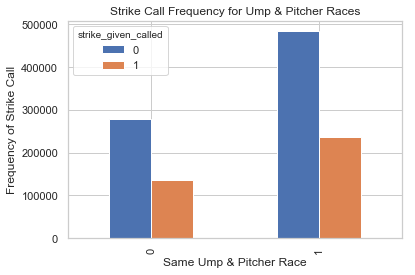

In [19]:
%matplotlib inline
pd.crosstab(xy_df.upm,xy_df.strike_given_called).plot(kind='bar')
plt.title('Strike Call Frequency for Ump & Pitcher Races')
plt.xlabel('Same Ump & Pitcher Race')
plt.ylabel('Frequency of Strike Call')

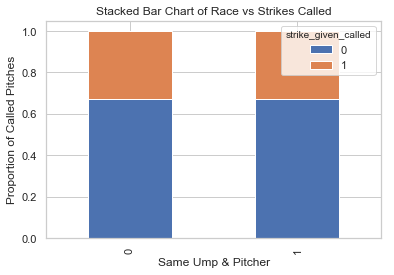

In [32]:
table=pd.crosstab(xy_df.upm,xy_df.strike_given_called)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Race vs Strikes Called')
plt.xlabel('Same Ump & Pitcher')
plt.ylabel('Proportion of Called Pitches')
plt.savefig('proportion_calls', bbox_inches='tight')

### Observations
- Whether the umpire and pitcher are the same race does not seem like a strong predictor for called strikes based on the visualization.

## Home/Away vs Strike Calls

Text(0, 0.5, 'Frequency of Strike Call')

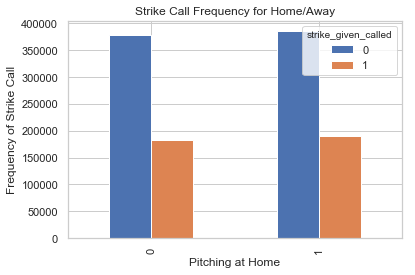

In [21]:
%matplotlib inline
pd.crosstab(xy_df.home_pitcher,xy_df.strike_given_called).plot(kind='bar')
plt.title('Strike Call Frequency for Home/Away')
plt.xlabel('Pitching at Home')
plt.ylabel('Frequency of Strike Call')

Text(0, 0.5, 'Proportion of Called Pitches')

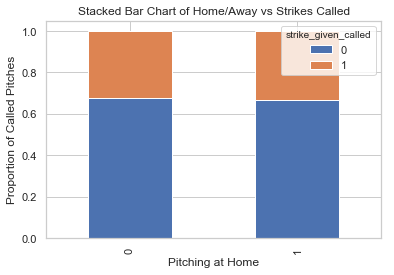

In [22]:
table=pd.crosstab(xy_df.home_pitcher,xy_df.strike_given_called)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Home/Away vs Strikes Called')
plt.xlabel('Pitching at Home')
plt.ylabel('Proportion of Called Pitches')

### Observations
- Whether the pitcher is at home or not does not seem like a strong predictor for called strikes based on the visualization.

# Over-sampling Using SMOTE
To balance the training data.

In [ ]:
X = xy_df.loc[:, xy_df.columns != 'strike_given_called']
y = xy_df.loc[:, xy_df.columns == 'strike_given_called']
# from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['strike_given_called'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of ball calls in oversampled data",len(os_data_y[os_data_y['strike_given_called']==0]))
print("Number of strike calls",len(os_data_y[os_data_y['strike_given_called']==1]))
print("Proportion of ball calls data in oversampled data is ",len(os_data_y[os_data_y['strike_given_called']==0])/len(os_data_X))
print("Proportion of strike calls data in oversampled data is ",len(os_data_y[os_data_y['strike_given_called']==1])/len(os_data_X))

# Recursive Feature Elimination
Repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features.

In this case, 5 features are choosen.

In [ ]:
xy_df_vars=xy_df.columns.values.tolist()
y=['strike_given_called']
X=[i for i in xy_df_vars if i not in y]
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(fit_intercept=True)
rfe = RFE(logreg, 5)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

### Observations
The RFE has helped us select the following features:
'count_0-1', 'count_0-2', 'count_1-2', 'count_2-2', 'count_3-2'.

These counts may be significant because a 0-2 count is uncommon suggesting that the umpire is more likely to call a ball on a 0-1 count. The other counts are terminal counts.

'upm' was determined not to be a high performing feature and removed. However, we can keep it to test our hypothesis.

In [ ]:
cols=['upm', 'count_0-1', 'count_0-2', 'count_1-2', 'count_2-2', 'count_3-2'] 
X=os_data_X[cols]
y=os_data_y['strike_given_called']

# Implementing the model

In [ ]:
# import statsmodels.api as sm
X = sm.add_constant(X)

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

# Logistic Regression Model Fitting

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

### Predicting the test set results and calculating the accuracy

In [ ]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

In [ ]:
# from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))